# **Homework 1: Linear Regression**

本次目標：由前 9 個小時的 18 個 features (包含 PM2.5)預測的 10 個小時的 PM2.5。<!-- 可以參考 <link> 獲知更細項的作業說明。-->

<!-- 首先，從 https://drive.google.com/open?id=1El0zvTkrSuqCTDcMpijXpADvJzZC2Jpa 將整個資料夾下載下來，並將下載下來的資料夾放到自己的 Google Drive（注意：上傳到自己 Google Drive 的是資料夾 hw1-regression，而非壓縮檔） -->


若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

# **Load 'train.csv'**
train.csv 的資料為 12 個月中，每個月取 20 天，每天 24 小時的資料(每小時資料有 18 個 features)。

In [1]:
import sys
import pandas as pd
import numpy as np
from google.colab import drive 
!gdown --id '1wNKAxQ29G15kgpBy_asjTcZRRgmsCZRm' --output data.zip
!unzip data.zip
# data = pd.read_csv('gdrive/My Drive/hw1-regression/train.csv', header = None, encoding = 'big5')
data = pd.read_csv('./train.csv', encoding = 'big5')

Downloading...
From: https://drive.google.com/uc?id=1wNKAxQ29G15kgpBy_asjTcZRRgmsCZRm
To: /content/data.zip
100% 177k/177k [00:00<00:00, 53.3MB/s]
Archive:  data.zip
  inflating: test.csv                
  inflating: train.csv               


# **Preprocessing** 
取需要的數值部分，將 'RAINFALL' 欄位全部補 0。
另外，如果要在 colab 重覆這段程式碼的執行，請從頭開始執行(把上面的都重新跑一次)，以避免跑出不是自己要的結果（若自己寫程式不會遇到，但 colab 重複跑這段會一直往下取資料。意即第一次取原本資料的第三欄之後的資料，第二次取第一次取的資料掉三欄之後的資料，...）。

In [2]:
data = data.iloc[:, 3:]
data[data == 'NR'] = 0
raw_data = data.to_numpy()

# **Extract Features (1)**
![圖片說明](https://drive.google.com/uc?id=1LyaqD4ojX07oe5oDzPO99l9ts5NRyArH)
![圖片說明](https://drive.google.com/uc?id=1ZroBarcnlsr85gibeqEF-MtY13xJTG47)

將原始 4320 * 18 的資料依照每個月分重組成 12 個 18 (features) * 480 (hours) 的資料。 

In [3]:
month_data = {}
for month in range(12):
    sample = np.empty([18, 480])
    for day in range(20):
        sample[:, day * 24 : (day + 1) * 24] = raw_data[18 * (20 * month + day) : 18 * (20 * month + day + 1), :]
    month_data[month] = sample

# **Extract Features (2)**
![alt text](https://drive.google.com/uc?id=1wKoPuaRHoX682LMiBgIoOP4PDyNKsJLK)
![alt text](https://drive.google.com/uc?id=1FRWWiXQ-Qh0i9tyx0LiugHYF_xDdkhLN)

每個月會有 480hrs，每 9 小時形成一個 data，每個月會有 471 個 data，故總資料數為 471 * 12 筆，而每筆 data 有 9 * 18 的 features (一小時 18 個 features * 9 小時)。

對應的 target 則有 471 * 12 個(第 10 個小時的 PM2.5)

In [95]:
x = np.empty([12 * 471, 18 * 9], dtype = float)
y = np.empty([12 * 471, 1], dtype = float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14:
                continue
            x[month * 471 + day * 24 + hour, :] = month_data[month][:,day * 24 + hour : day * 24 + hour + 9].reshape(1, -1) #vector dim:18*9 (9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9)
            y[month * 471 + day * 24 + hour, 0] = month_data[month][9, day * 24 + hour + 9] #value
print(x)
print(y)

[[14.  14.  14.  ...  2.   2.   0.5]
 [14.  14.  13.  ...  2.   0.5  0.3]
 [14.  13.  12.  ...  0.5  0.3  0.8]
 ...
 [17.  18.  19.  ...  1.1  1.4  1.3]
 [18.  19.  18.  ...  1.4  1.3  1.6]
 [19.  18.  17.  ...  1.3  1.6  1.8]]
[[30.]
 [41.]
 [44.]
 ...
 [17.]
 [24.]
 [29.]]


# **Normalize (1)**


In [96]:
mean_x = np.mean(x, axis = 0) #18 * 9 
std_x = np.std(x, axis = 0) #18 * 9 
for i in range(len(x)): #12 * 471
    for j in range(len(x[0])): #18 * 9 
        if std_x[j] != 0:
            x[i][j] = (x[i][j] - mean_x[j]) / std_x[j]
x

array([[-1.35825331, -1.35883937, -1.359222  , ...,  0.26650729,
         0.2656797 , -1.14082131],
       [-1.35825331, -1.35883937, -1.51819928, ...,  0.26650729,
        -1.13963133, -1.32832904],
       [-1.35825331, -1.51789368, -1.67717656, ..., -1.13923451,
        -1.32700613, -0.85955971],
       ...,
       [-0.88092053, -0.72262212, -0.56433559, ..., -0.57693779,
        -0.29644471, -0.39079039],
       [-0.7218096 , -0.56356781, -0.72331287, ..., -0.29578943,
        -0.39013211, -0.1095288 ],
       [-0.56269867, -0.72262212, -0.88229015, ..., -0.38950555,
        -0.10906991,  0.07797893]])

#**Split Training Data Into "train_set" and "validation_set"**
這部分是針對作業中 report 的第二題、第三題做的簡單示範，以生成比較中用來訓練的 train_set 和不會被放入訓練、只是用來驗證的 validation_set。

In [97]:
import math
x_train_set = x[: math.floor(len(x) * 0.8), :]
y_train_set = y[: math.floor(len(y) * 0.8), :]
x_validation = x[math.floor(len(x) * 0.8): , :]
y_validation = y[math.floor(len(y) * 0.8): , :]
print(x_train_set)
print(y_train_set)
print(x_validation)
print(y_validation)
print(len(x_train_set))
print(len(y_train_set))
print(len(x_validation))
print(len(y_validation))

[[-1.35825331 -1.35883937 -1.359222   ...  0.26650729  0.2656797
  -1.14082131]
 [-1.35825331 -1.35883937 -1.51819928 ...  0.26650729 -1.13963133
  -1.32832904]
 [-1.35825331 -1.51789368 -1.67717656 ... -1.13923451 -1.32700613
  -0.85955971]
 ...
 [ 0.86929969  0.70886668  0.38952809 ...  1.39110073  0.2656797
  -0.39079039]
 [ 0.71018876  0.39075806  0.07157353 ...  0.26650729 -0.39013211
  -0.39079039]
 [ 0.3919669   0.07264944  0.07157353 ... -0.38950555 -0.39013211
  -0.85955971]]
[[30.]
 [41.]
 [44.]
 ...
 [ 7.]
 [ 5.]
 [14.]]
[[ 0.07374504  0.07264944  0.07157353 ... -0.38950555 -0.85856912
  -0.57829812]
 [ 0.07374504  0.07264944  0.23055081 ... -0.85808615 -0.57750692
   0.54674825]
 [ 0.07374504  0.23170375  0.23055081 ... -0.57693779  0.54674191
  -0.1095288 ]
 ...
 [-0.88092053 -0.72262212 -0.56433559 ... -0.57693779 -0.29644471
  -0.39079039]
 [-0.7218096  -0.56356781 -0.72331287 ... -0.29578943 -0.39013211
  -0.1095288 ]
 [-0.56269867 -0.72262212 -0.88229015 ... -0.3895055

In [7]:
x_train_set.shape

(4521, 162)

# **Training**
![alt text](https://drive.google.com/uc?id=1xIXvqZ4EGgmxrp7c9r0LOVbcvd4d9H4N)
![alt text](https://drive.google.com/uc?id=1S42g06ON5oJlV2f9RukxawjbE4NpsaB6)
![alt text](https://drive.google.com/uc?id=1BbXu-oPB9EZBHDQ12YCkYqtyAIil3bGj)

(和上圖不同處: 下面的 code 採用 Root Mean Square Error)

因為常數項的存在，所以 dimension (dim) 需要多加一欄；eps 項是避免 adagrad 的分母為 0 而加的極小數值。

每一個 dimension (dim) 會對應到各自的 gradient, weight (w)，透過一次次的 iteration (iter_time) 學習。

## 以下手刻實作Linear Regression

M(w) = wx + b

loss = sum( (M(w) - y)^2)

gradient = 2/sqrt(L) * x * sum(y - M(w) )/N

# 遞迴找出最佳learning rate

In [179]:
from tqdm.notebook import trange
x_lose = []
x_val_lose = []


for lr in trange(10, 50, 10):

  dim = x_train_set.shape[1] + 1 #bias
  w = np.zeros([dim, 1])
  x = np.concatenate((np.ones([x_train_set.shape[0], 1]), x_train_set), axis=1).astype(float)
  x_val = np.concatenate((np.ones([x_validation.shape[0], 1]), x_validation), axis=1).astype(float)
  y = y_train_set
  y_val = y_validation

  iter_time = 10001
  pre_gra = np.zeros([dim, 1])
  eps = 0.0000000001
  lose_change = []
  val_lose_change = []
  learning_rate = lr/10
  
  for i in trange(iter_time):
    y_m = np.dot(x, w)
    lose = np.sqrt(np.sum(np.power(y-y_m, 2))/x.shape[0]) #display loss is rmse
    lose_change.append(lose)
    y_m_val = np.dot(x_val, w)
    val_lose = np.sqrt(np.sum(np.power(y_val-y_m_val, 2))/x_val.shape[0])
    val_lose_change.append(val_lose)

    #use squre error as to calculate gradient
    gradient = 2 * np.dot(x.transpose(), y_m - y) / x.shape[0] / lose
    pre_gra += gradient ** 2
    adagrad = np.sqrt(pre_gra + eps)
    w = w - learning_rate / adagrad * gradient
  x_lose.append(lose_change)
  x_val_lose.append(val_lose_change)


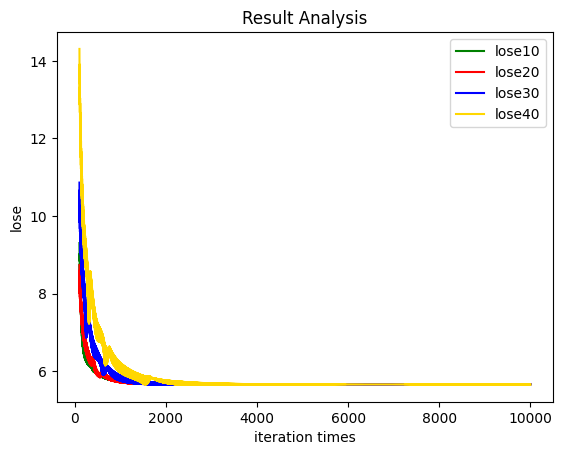

In [182]:
import matplotlib.pyplot as plt

plt.style.use('default')

plt.title('Result Analysis')
plt.plot(range(100,10000), x_val_lose[0][100:10000], color='green', label='lose10')
plt.plot(range(100,10000), x_val_lose[1][100:10000], color='red', label='lose20')
plt.plot(range(100,10000), x_val_lose[2][100:10000], color='blue', label='lose30')
plt.plot(range(100,10000), x_val_lose[3][100:10000], color='gold', label='lose40')

plt.legend()

plt.xlabel('iteration times')
plt.ylabel('lose')
plt.show()

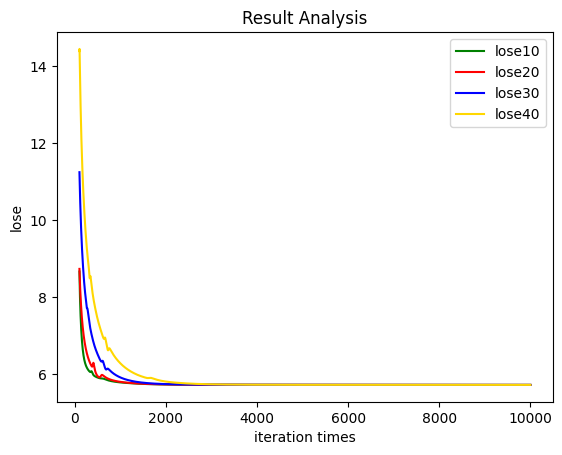

In [134]:
import matplotlib.pyplot as plt

plt.style.use('default')

plt.title('Result Analysis')
plt.plot(range(100,10000), x_lose[0][100:10000], color='green', label='lose10')
plt.plot(range(100,10000), x_lose[1][100:10000], color='red', label='lose20')
plt.plot(range(100,10000), x_lose[2][100:10000], color='blue', label='lose30')
plt.plot(range(100,10000), x_lose[3][100:10000], color='gold', label='lose40')

plt.legend()

plt.xlabel('iteration times')
plt.ylabel('lose')
plt.show()

不論在training set或validattion set上，learning rate 1 收斂速度較快

以下採用learning rate = 1

將validation set 與training set合併 重新訓練

In [197]:
x = np.concatenate((x_train_set, x_validation), axis=0).astype(float)
y = np.concatenate((y_train_set, y_validation), axis=0).astype(float)

In [148]:
x.shape

(5652, 162)

In [198]:
from tqdm.notebook import trange

dim = x.shape[1] + 1 #bias
w = np.zeros([dim, 1])
x = np.concatenate((np.ones([x.shape[0], 1]), x), axis=1).astype(float)

iter_time = 6000
pre_gra = np.zeros([dim, 1])
eps = 0.0000000001
learning_rate = 1

for i in trange(iter_time):
  y_m = np.dot(x, w)
  lose = np.sqrt(np.sum(np.power(y-y_m, 2))/x.shape[0]) #display loss is rmse

  #use squre error as to calculate gradient
  gradient = 2 * np.dot(x.transpose(), y_m - y) / x.shape[0] / lose
  pre_gra += gradient ** 2
  adagrad = np.sqrt(pre_gra + eps)
  w = w - learning_rate / adagrad * gradient

y_m = np.dot(x, w)
lose = np.sqrt(np.sum(np.power(y-y_m, 2))/x.shape[0])
print("Final lose is %f"%(lose))



Final lose is 5.681728


# **Testing**
![alt text](https://drive.google.com/uc?id=1165ETzZyE6HStqKvgR0gKrJwgFLK6-CW)

載入 test data，並且以相似於訓練資料預先處理和特徵萃取的方式處理，使 test data 形成 240 個維度為 18 * 9 + 1 的資料。

In [167]:
# testdata = pd.read_csv('gdrive/My Drive/hw1-regression/test.csv', header = None, encoding = 'big5')
testdata = pd.read_csv('./test.csv', header = None, encoding = 'big5')
test_data = testdata.iloc[:, 2:]
test_data[test_data == 'NR'] = 0
test_data = test_data.to_numpy()
test_x = np.empty([240, 18*9], dtype = float)
for i in range(240):
    test_x[i, :] = test_data[18 * i: 18* (i + 1), :].reshape(1, -1)
for i in range(len(test_x)):
    for j in range(len(test_x[0])):
        if std_x[j] != 0:
            test_x[i][j] = (test_x[i][j] - mean_x[j]) / std_x[j]
test_x = np.concatenate((np.ones([240, 1]), test_x), axis = 1).astype(float)
test_x

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2986: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


array([[ 1.        , -0.24447681, -0.24545919, ..., -0.67065391,
        -1.04594393,  0.07797893],
       [ 1.        , -1.35825331, -1.51789368, ...,  0.17279117,
        -0.10906991, -0.48454426],
       [ 1.        ,  1.5057434 ,  1.34508393, ..., -1.32666675,
        -1.04594393, -0.57829812],
       ...,
       [ 1.        ,  0.3919669 ,  0.54981237, ...,  0.26650729,
        -0.20275731,  1.20302531],
       [ 1.        , -1.8355861 , -1.8360023 , ..., -1.04551839,
        -1.13963133, -1.14082131],
       [ 1.        , -1.35825331, -1.35883937, ...,  2.98427476,
         3.26367657,  1.76554849]])

# **Prediction**
說明圖同上

![alt text](https://drive.google.com/uc?id=1165ETzZyE6HStqKvgR0gKrJwgFLK6-CW)

有了 weight 和測試資料即可預測 target。

In [ ]:
#w = np.load('weight.npy')
ans_y = np.dot(test_x, w)
ans_y

# **Save Prediction to CSV File**


In [ ]:
import csv
with open('submission.csv', mode='w', newline='') as submit_file:
    csv_writer = csv.writer(submit_file)
    header = ['id', 'value']
    print(header)
    csv_writer.writerow(header)
    for i in range(240):
        row = ['id_' + str(i), ans_y[i][0]]
        csv_writer.writerow(row)
        print(row)

In [156]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [202]:
!gdown --id 1VoF-D1FH0PhIne0pdDMKNmSg-SXfBoKS
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

Downloading...
From: https://drive.google.com/uc?id=1VoF-D1FH0PhIne0pdDMKNmSg-SXfBoKS
To: /content/drive/My Drive/NTUEE_MachineLearning2020/HW1 - Regression/kaggle.json
100% 65.0/65.0 [00:00<00:00, 116kB/s]
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [201]:
!kaggle competitions submit -c ml2020spring-hw1 -f submission.csv -m "Message"

100% 6.11k/6.11k [00:00<00:00, 29.3kB/s]
Successfully submitted to ML2020spring - hw1

Result: 

Private Score: 7.43274

Public Score: 5.44760


![alt text](https://drive.google.com/uc?id=1OUAK1JOM6fDTA8UiWf5yxYAS3XGjj0TB)

Rank 172/423
![alt text](https://drive.google.com/uc?id=1hVgipdLOofOyWq2k7xPnxINB_Pc27PGV)